# Step4: test

In [5]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import glob
import cv2
from torchvision.utils import save_image
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns;sns.set()
from torchsummary import summary

torch.manual_seed(0)

In [3]:
def test_img(model_path, test_images):
  global patch
  test_patches = patch(test_images)

  loss_func = nn.MSELoss()
  new_model = Autoencoder4().to(device)
  new_model.load_state_dict(torch.load(model_path))
  new_model.eval()
  FP=0;TP=0;TN=0;FN=0;
  y_true = []
  y_pred = []
  img_idx=0
  for patch in test_patches:

    if img_idx<28:
        y_true.append(0) #정상
    else:
        y_true.append(1)

    defectness_list = []
    for patch_idx in range(256):
      one_patch = patch[patch_idx].view(1,1,64,64)
      one_patch = Variable(one_patch).cuda()
      pred = new_model(one_patch)
      loss = loss_func(pred, one_patch)
      defectness = patch_prediction(loss, 0.0028) # T / F값이 리턴됨

      defectness_list.append(defectness)
    image_defectness = image_prediction(3, defectness_list)

    if img_idx < 28:
      if image_defectness == True:
        y_pred.append(1)
      else:
        y_pred.append(0)
    else:
      if image_defectness == True:
        y_pred.append(1)
      else:
        y_pred.append(0)

    plt.imshow(np.transpose(test_images[img_idx].view(256,4096), (0, 1)), cmap="gray")
    plt.show()
    print("patch defect is {}.".format(sum(defectness_list)))
    if image_defectness == True:
      print("fabric #",img_idx," is DEFECT.")
    else:
      print("fabric #",img_idx," is nodefect.")
    print()
    print()
    img_idx +=1
  
  print("f1score = ",f1_score(y_true, y_pred))
  
  confusion_matrix2= confusion_matrix(y_true, y_pred)
  sns.heatmap(confusion_matrix2.T, annot=True,fmt='d',
              xticklabels=['nodefect','defect'], yticklabels=['nodefect','defect'],cmap="YlGnBu")
  plt.xlabel('true')
  plt.ylabel('predicted')
  plt.title('Confusion Matirx', fontsize=20)

In [22]:
model_path = "./model/finalepoch/Autoencoder4.pth" # 성능평가에서 제일 좋았던 걸로 선택
image_path =  "./data/nocrop/test/*.png"
test_images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob(image_path))] 

In [23]:
def patch(images):
  patch_size = 64
  global patch
  global patches
  for i in range(len(images)):
    images[i] = transforms.ToTensor()((images[i]))
    # unfold로 shape조절 --> view --> [patch개수, patch_size, patch_size]
    patches = images[i].data.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size) 
    patches = patches.contiguous().view(-1, patch_size, patch_size) 

    if i == 0:
      patch = patches
    if i > 0:
      patches = torch.cat((patch, patches))
      patch = patches

  patches = patches.view(len(images), -1, patch_size, patch_size) 
  return patches

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64*64, 1000),
            nn.Linear(1000, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 1000),
            nn.Linear(1000, 64*64) 
        )        
    def forward(self,x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
        return out

class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64*64, 32*32),
            nn.PReLU(32*32),
            nn.Linear(32*32, 16*16),
            nn.PReLU(16*16),
            nn.Linear(16*16,4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 16*16),
            nn.PReLU(16*16),
            nn.Linear(16*16, 32*32),
            nn.PReLU(32*32),
            nn.Linear(32*32, 64*64)
        )   
                
    def forward(self,x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
       # out = self.decoder(encoded)
        out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
        return out

class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3,self).__init__()
        self.encoder = nn.Sequential (
          # conv 1
          nn.Conv2d(in_channels= 1, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # # conv 2
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 3
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64),

          # # conv 4
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(128),

          # # conv 5
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(256)
        )

        self.decoder = nn.Sequential (
          # # conv 6
          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(128),

          # # conv 7
          nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64),

          # # conv 8
          nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 9
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # conv 10
          nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
          nn.Tanh()
        )

    def forward(self, x):
      encoded = self.encoder(x)
      out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
      return out


class Autoencoder4(nn.Module):
    def __init__(self):
        super(Autoencoder4,self).__init__()
        self.encoder = nn.Sequential (
          # conv 1
          nn.Conv2d(in_channels= 1, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # # conv 2
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 3
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64),

          # # conv 4
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(128),

          # # conv 5
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(256)
        )

        self.decoder = nn.Sequential (
          # # conv 6
          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(128),

          # # conv 7
          nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64),

          # # conv 8
          nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 9
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # conv 10
          nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
          nn.Sigmoid()
        )

    def forward(self, x):
      encoded = self.encoder(x)
      out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
      return out

class Autoencoder5(nn.Module):
    def __init__(self):
        super(Autoencoder5,self).__init__()
        self.encoder = nn.Sequential (
          # conv 1
          nn.Conv2d(in_channels= 1, out_channels=16, kernel_size=3, stride=3, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # # conv 2
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=3, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 3
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(64)
        )

        self.decoder = nn.Sequential (
          # # conv 4
          nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(32),

          # # conv 5
          nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=3, padding=1),
          nn.PReLU(),
          nn.BatchNorm2d(16),

          # conv 5
          nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=3, padding=1),
          nn.Sigmoid()
        )

    def forward(self, x):
      encoded = self.encoder(x)
      out = self.decoder(encoded).view(x.size(0), 1, 64, 64)
      return out


In [25]:
"""
defect로 판단된 patch 개수가 threshold이상이면,
해당 이미지를 defect로 판단하여 True를 return한다.
"""
def image_prediction(patch_num_threshold, defectness_list):
  defect_num = sum(defectness_list)
  if (defect_num >= patch_num_threshold):
    return True # defect patch가 k개 이상이면, 해당 이미지는 defect(True)
  return False
"""
patch 한 개에 대한 loss값이 threshold이상이면,
해당 patch를 defect를 판단하여 True를 return한다.
"""
def patch_prediction(loss, patch_threshold):
  if loss >= patch_threshold :
    return True
  else: 
    return False

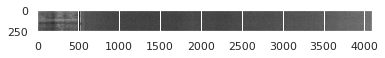

patch defect is 79.
fabric # 0  is DEFECT.




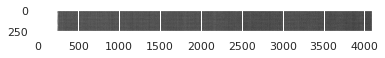

patch defect is 91.
fabric # 1  is DEFECT.




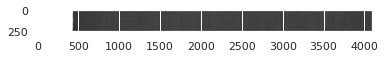

patch defect is 0.
fabric # 2  is nodefect.




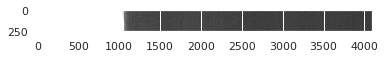

patch defect is 14.
fabric # 3  is DEFECT.




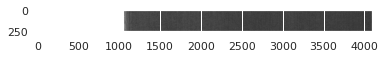

patch defect is 20.
fabric # 4  is DEFECT.




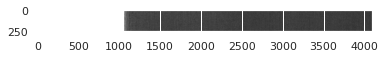

patch defect is 14.
fabric # 5  is DEFECT.




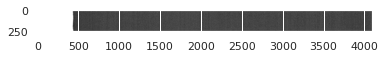

patch defect is 0.
fabric # 6  is nodefect.




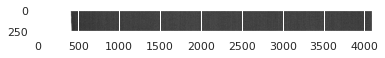

patch defect is 0.
fabric # 7  is nodefect.




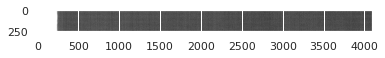

patch defect is 84.
fabric # 8  is DEFECT.




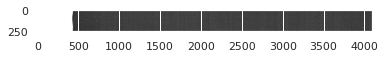

patch defect is 0.
fabric # 9  is nodefect.




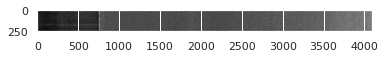

patch defect is 57.
fabric # 10  is DEFECT.




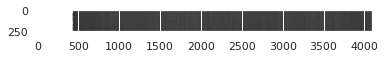

patch defect is 0.
fabric # 11  is nodefect.




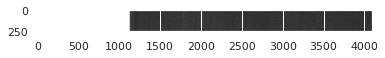

patch defect is 0.
fabric # 12  is nodefect.




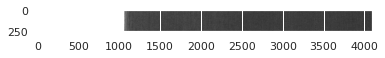

patch defect is 11.
fabric # 13  is DEFECT.




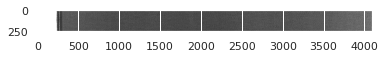

patch defect is 33.
fabric # 14  is DEFECT.




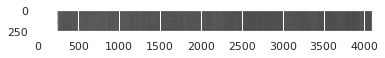

patch defect is 115.
fabric # 15  is DEFECT.




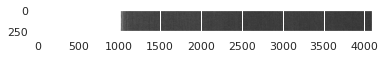

patch defect is 37.
fabric # 16  is DEFECT.




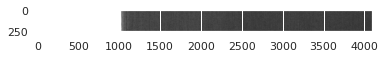

patch defect is 35.
fabric # 17  is DEFECT.




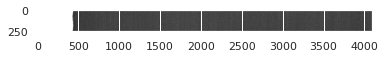

patch defect is 0.
fabric # 18  is nodefect.




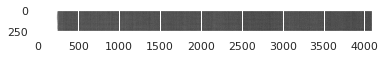

patch defect is 93.
fabric # 19  is DEFECT.




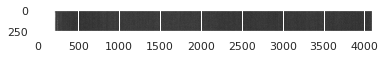

patch defect is 0.
fabric # 20  is nodefect.




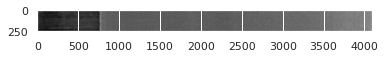

patch defect is 80.
fabric # 21  is DEFECT.




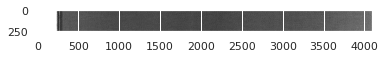

patch defect is 43.
fabric # 22  is DEFECT.




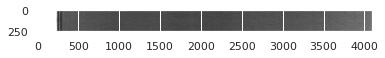

patch defect is 44.
fabric # 23  is DEFECT.




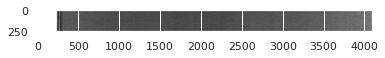

patch defect is 81.
fabric # 24  is DEFECT.




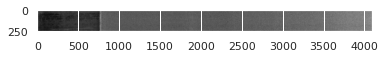

patch defect is 77.
fabric # 25  is DEFECT.




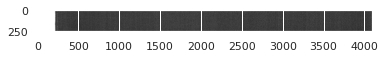

patch defect is 0.
fabric # 26  is nodefect.




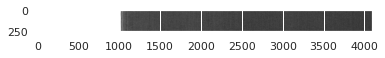

patch defect is 43.
fabric # 27  is DEFECT.




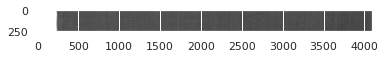

patch defect is 173.
fabric # 28  is DEFECT.




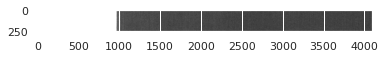

patch defect is 80.
fabric # 29  is DEFECT.




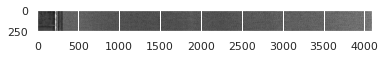

patch defect is 42.
fabric # 30  is DEFECT.




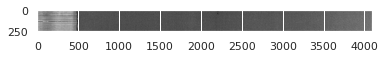

patch defect is 89.
fabric # 31  is DEFECT.




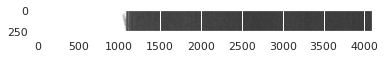

patch defect is 159.
fabric # 32  is DEFECT.




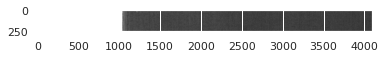

patch defect is 29.
fabric # 33  is DEFECT.




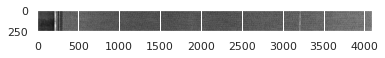

patch defect is 28.
fabric # 34  is DEFECT.




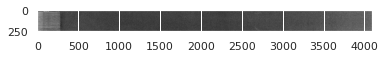

patch defect is 54.
fabric # 35  is DEFECT.




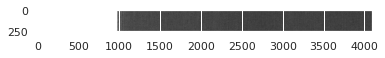

patch defect is 69.
fabric # 36  is DEFECT.




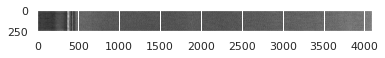

patch defect is 90.
fabric # 37  is DEFECT.




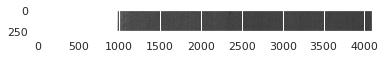

patch defect is 182.
fabric # 38  is DEFECT.




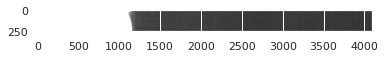

patch defect is 1.
fabric # 39  is nodefect.




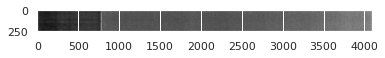

patch defect is 73.
fabric # 40  is DEFECT.




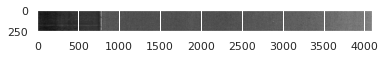

patch defect is 67.
fabric # 41  is DEFECT.




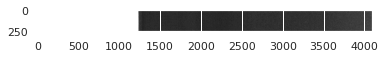

patch defect is 0.
fabric # 42  is nodefect.




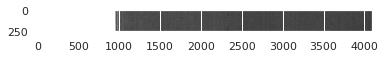

patch defect is 194.
fabric # 43  is DEFECT.




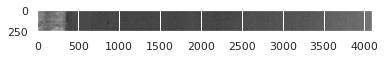

patch defect is 124.
fabric # 44  is DEFECT.




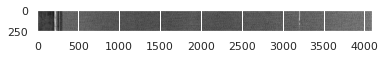

patch defect is 29.
fabric # 45  is DEFECT.




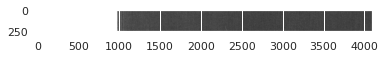

patch defect is 84.
fabric # 46  is DEFECT.




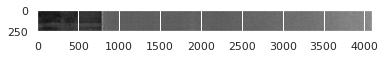

patch defect is 80.
fabric # 47  is DEFECT.




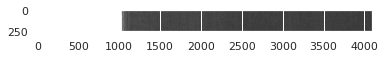

patch defect is 38.
fabric # 48  is DEFECT.




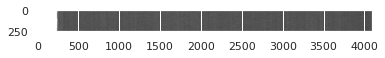

patch defect is 180.
fabric # 49  is DEFECT.




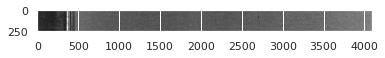

patch defect is 35.
fabric # 50  is DEFECT.




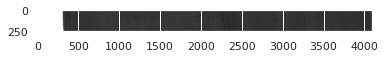

patch defect is 0.
fabric # 51  is nodefect.




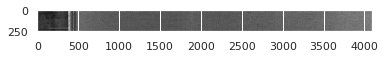

patch defect is 110.
fabric # 52  is DEFECT.




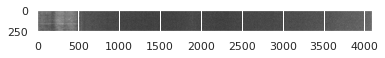

patch defect is 67.
fabric # 53  is DEFECT.




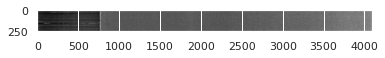

patch defect is 75.
fabric # 54  is DEFECT.




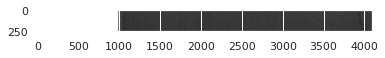

patch defect is 0.
fabric # 55  is nodefect.




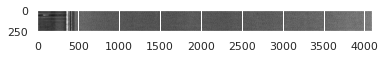

patch defect is 87.
fabric # 56  is DEFECT.




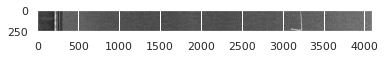

patch defect is 32.
fabric # 57  is DEFECT.




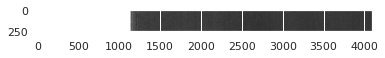

patch defect is 0.
fabric # 58  is nodefect.




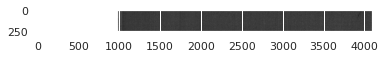

patch defect is 0.
fabric # 59  is nodefect.




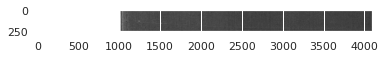

patch defect is 180.
fabric # 60  is DEFECT.




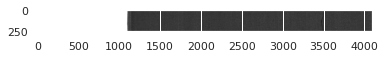

patch defect is 0.
fabric # 61  is nodefect.




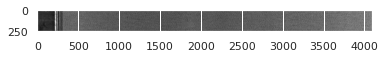

patch defect is 60.
fabric # 62  is DEFECT.




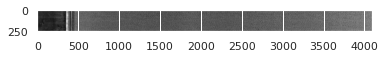

patch defect is 69.
fabric # 63  is DEFECT.




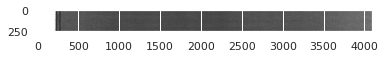

patch defect is 51.
fabric # 64  is DEFECT.




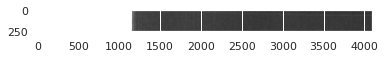

patch defect is 0.
fabric # 65  is nodefect.




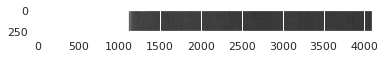

patch defect is 1.
fabric # 66  is nodefect.




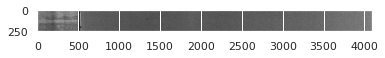

patch defect is 75.
fabric # 67  is DEFECT.




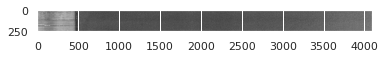

patch defect is 97.
fabric # 68  is DEFECT.




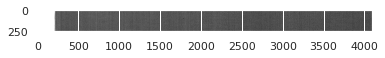

patch defect is 134.
fabric # 69  is DEFECT.




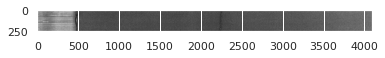

patch defect is 125.
fabric # 70  is DEFECT.




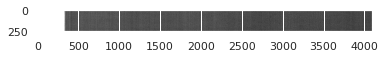

patch defect is 32.
fabric # 71  is DEFECT.




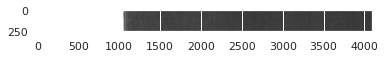

patch defect is 14.
fabric # 72  is DEFECT.




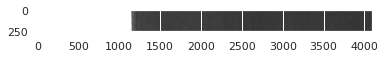

patch defect is 1.
fabric # 73  is nodefect.




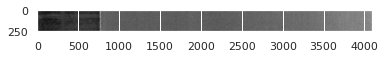

patch defect is 81.
fabric # 74  is DEFECT.




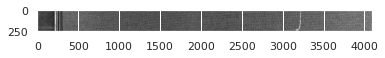

patch defect is 163.
fabric # 75  is DEFECT.




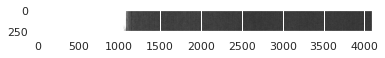

patch defect is 11.
fabric # 76  is DEFECT.




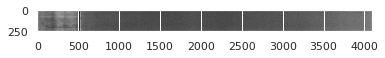

patch defect is 77.
fabric # 77  is DEFECT.




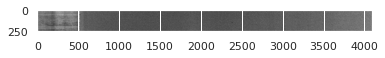

patch defect is 74.
fabric # 78  is DEFECT.




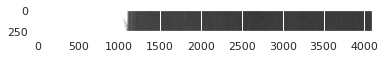

patch defect is 2.
fabric # 79  is nodefect.




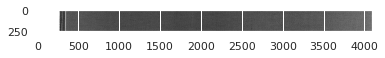

patch defect is 40.
fabric # 80  is DEFECT.


f1score =  0.7368421052631579


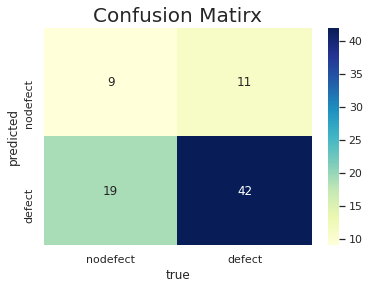

In [26]:
test_img(model_path, test_images) # 3 0.0028